### DATASET: Primary school temporal network data

This data set contains the temporal network of contacts between the children and teachers used in the study published in BMC Infectious Diseases 2014, 14:695. The file contains a tab-separated list representing the active contacts during 20-second intervals of the data collection. Each line has the form “t i j Ci Cj”, where i and j are the anonymous IDs of the persons in contact, Ci and Cj are their classes, and the interval during which this contact was active is [ t – 20s, t ]. If multiple contacts are active in a given interval, you will see multiple lines starting with the same value of t. Time is measured in seconds.

In [1]:
import numpy             as np
import brainconn         as bc
import pandas            as pd
import xarray            as xr
import numba             as nb
import matplotlib.pyplot as plt
import leidenalg

import ctypes

from   tqdm              import tqdm
from   net.layerwise     import *

#### Define methods to load data

In [2]:
_DATA_PATH      = 'data-sets/primaryschool/primaryschool.csv'
_META_DATA_PATH = 'data-sets/primaryschool/metadata_primaryschool.txt'

In [3]:
def _load_data_as_adj(data_path, meta_data_path, verbose=False):
    # Loading data and metadata
    data     = pd.read_csv(data_path, header=None, delimiter='\t', usecols=[0,1,2], names=['t','i','j','Ci','Cj'])
    metadata = np.loadtxt(meta_data_path, usecols=(0,1), dtype=str)
    # Mapping nodes labels to indexes
    idx      = np.arange(metadata.shape[0], dtype=int)
    # Numerical labels to index
    n_labels = dict( zip(metadata[:,0].astype(int),idx) )
    # Literal labels to index
    s_labels = metadata[:,1]
    # Replacing nodes labes
    data['i'] = data['i'].map(n_labels)
    data['j'] = data['j'].map(n_labels)
    # Get sources and targets
    x_s   = data.groupby('t')['i'].apply(list)
    x_t   = data.groupby('t')['j'].apply(list)
    #times = x_s.index.values 
    # Convert to array
    x_s   = x_s.values
    x_t   = x_t.values
    # Get number of nodes and time-points
    n_nodes  = len(metadata[:,0])
    n_times  = len(x_s)
    times    = np.arange(n_times, dtype=int)
    # Adjacency tensor
    A   = np.zeros((n_nodes,n_nodes,n_times))
    itr = range(len(times))
    for t in tqdm(itr) if verbose else itr:
        A[x_s[t],x_t[t],t] = A[x_t[t],x_s[t],t] = 1
        np.fill_diagonal(A[...,t],1)
    # Convert to x-array
    A = xr.DataArray( A[:,:,None,:], dims=("sources", "targets", "trials", "times"),
                         coords={"sources":s_labels, 
                                 "targets":s_labels, 
                                 "times":times}
                    )
    return A

#### Load data as adjacency tensor

In [4]:
A = _load_data_as_adj(_DATA_PATH, _META_DATA_PATH, verbose=True)

100%|██████████| 3100/3100 [00:00<00:00, 27682.46it/s]


### Degree and Modularity time-series

In [22]:
# Computing degree time-series
d=compute_nodes_degree(A)
# Computing modularity time-series
## Igraph
p_ig,m_ig=compute_network_partition(A, kw_leiden={}, verbose=True, backend='igraph', n_jobs=1)
# Brainconn
p_bc,m_bc=compute_network_partition(A, kw_louvain={'gamma': 1}, verbose=True, backend='brainconn', n_jobs=-1)

100%|██████████| 3100/3100 [00:12<00:00, 251.77it/s]


  0%|          |  : 0/3100 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3100 out of 3100 | elapsed:  3.4min finished


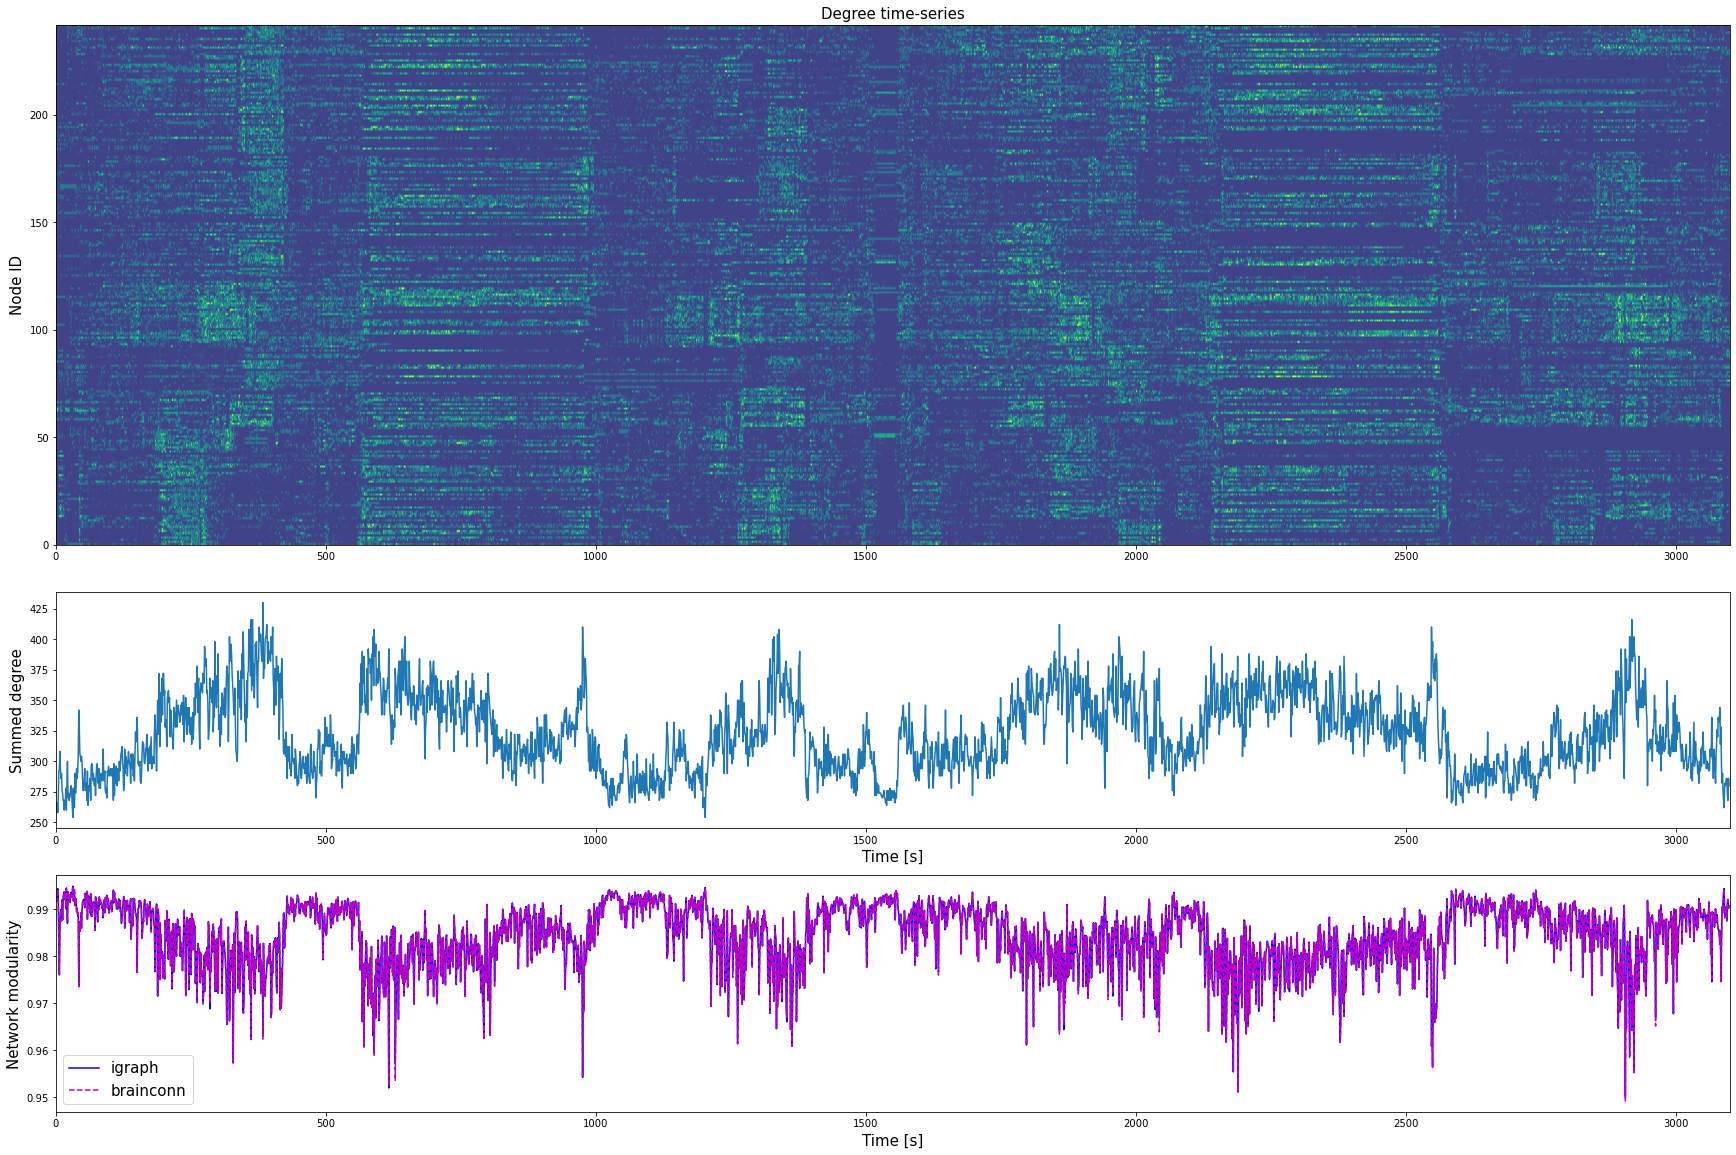

In [7]:
plt.figure(figsize=(30,20))
plt.subplot2grid((4,3),(0,0),rowspan=2,colspan=3)
plt.imshow( d.isel(trials=0), aspect='auto', cmap='viridis', origin='lower', extent=[0, A.sizes['times'], 0, A.sizes['sources']], vmin=0, vmax=5)
plt.ylabel('Node ID', fontsize=15)
#plt.yticks(range(A.sizes['sources']),A.sources.values)
plt.title('Degree time-series', fontsize=15)
plt.subplot2grid((4,3),(2,0),rowspan=1,colspan=3)
plt.plot(d.isel(trials=0).sum(dim='roi').values )
plt.xlim(0, A.sizes['times']);
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Summed degree', fontsize=15)
plt.subplot2grid((4,3),(3,0),rowspan=1,colspan=3)
plt.plot( m_ig.isel(trials=0), 'b'  , label='igraph')
plt.plot( m_bc.isel(trials=0), 'm--', label='brainconn' )
plt.xlim(0, A.sizes['times']);
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Network modularity', fontsize=15)
plt.legend(fontsize=15);

### Nodes' coreness

In [13]:
k_core = compute_nodes_coreness(A, verbose=False, n_jobs=-1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

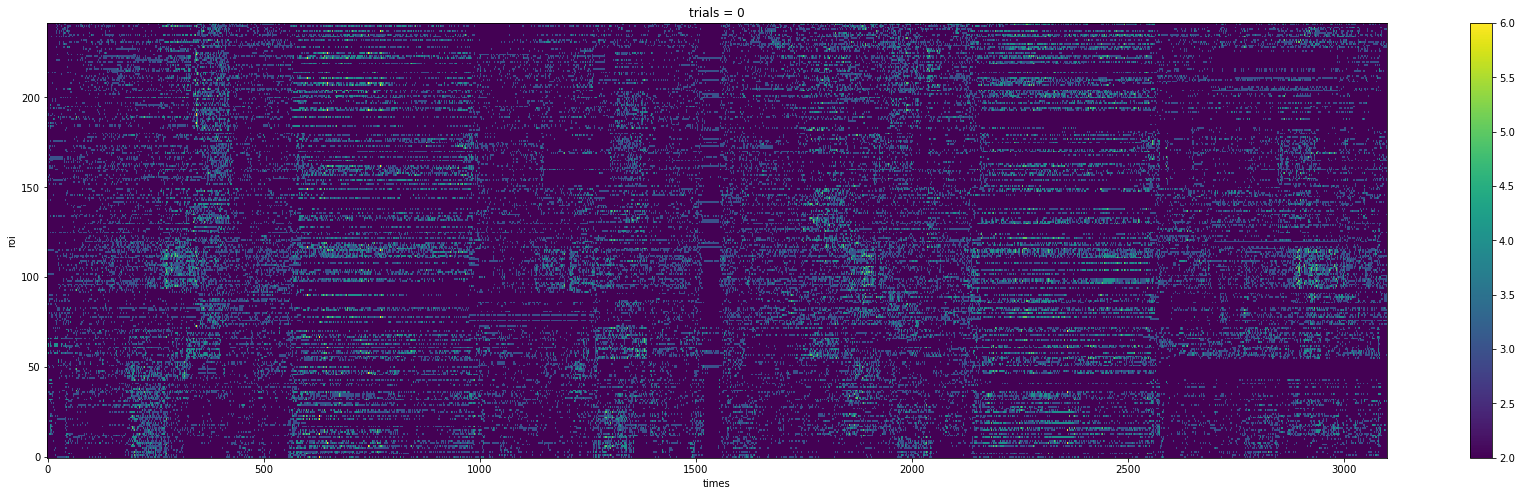

In [20]:
plt.figure(figsize=(30,8))
k_core.isel(trials=0).plot.imshow(x="times",y="roi")

### Network partitions

In [8]:
# Estimating partitions using igraph
# p_ig = compute_network_partition(A, verbose=False, backend='igraph', n_jobs=-1)

In [8]:
# Estimating partitions using brainconn
# p_bc = compute_network_partition(A, verbose=False, backend='brainconn', n_jobs=-1)

Text(0.5, 1.0, 'Affiliation vector - Brainconn')

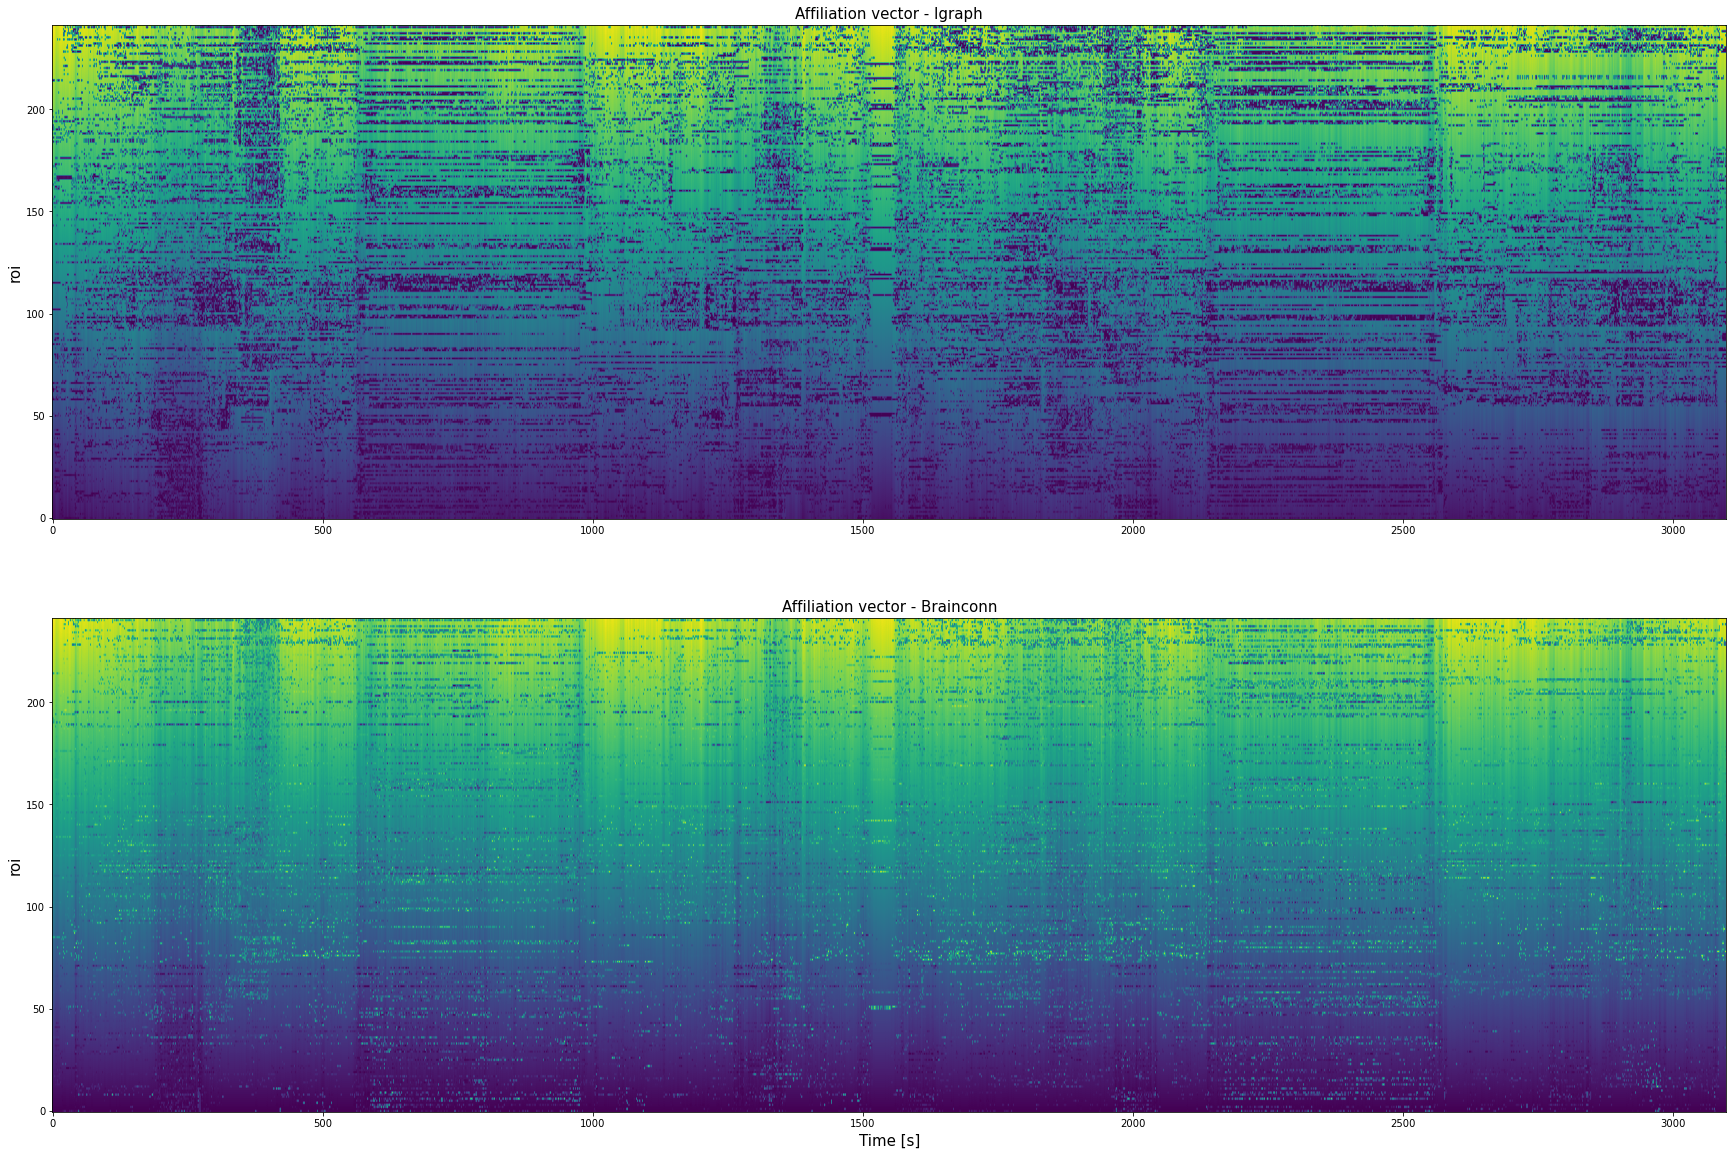

In [9]:
plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
plt.imshow(p_ig.isel(trials=0), aspect='auto', cmap='viridis', origin='lower')
plt.ylabel('roi', fontsize=15)
plt.title('Affiliation vector - Igraph', fontsize=15)
plt.subplot(2,1,2)
plt.imshow(p_bc.isel(trials=0), aspect='auto', cmap='viridis', origin='lower')
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('roi', fontsize=15)
plt.title('Affiliation vector - Brainconn', fontsize=15)

#### Nodes' allegiance matrix

In [5]:
T_ig = compute_allegiance_matrix(A, verbose=False, backend='igraph', n_jobs=1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

In [6]:
T_bc = compute_allegiance_matrix(A, verbose=False, backend='brainconn', n_jobs=-1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

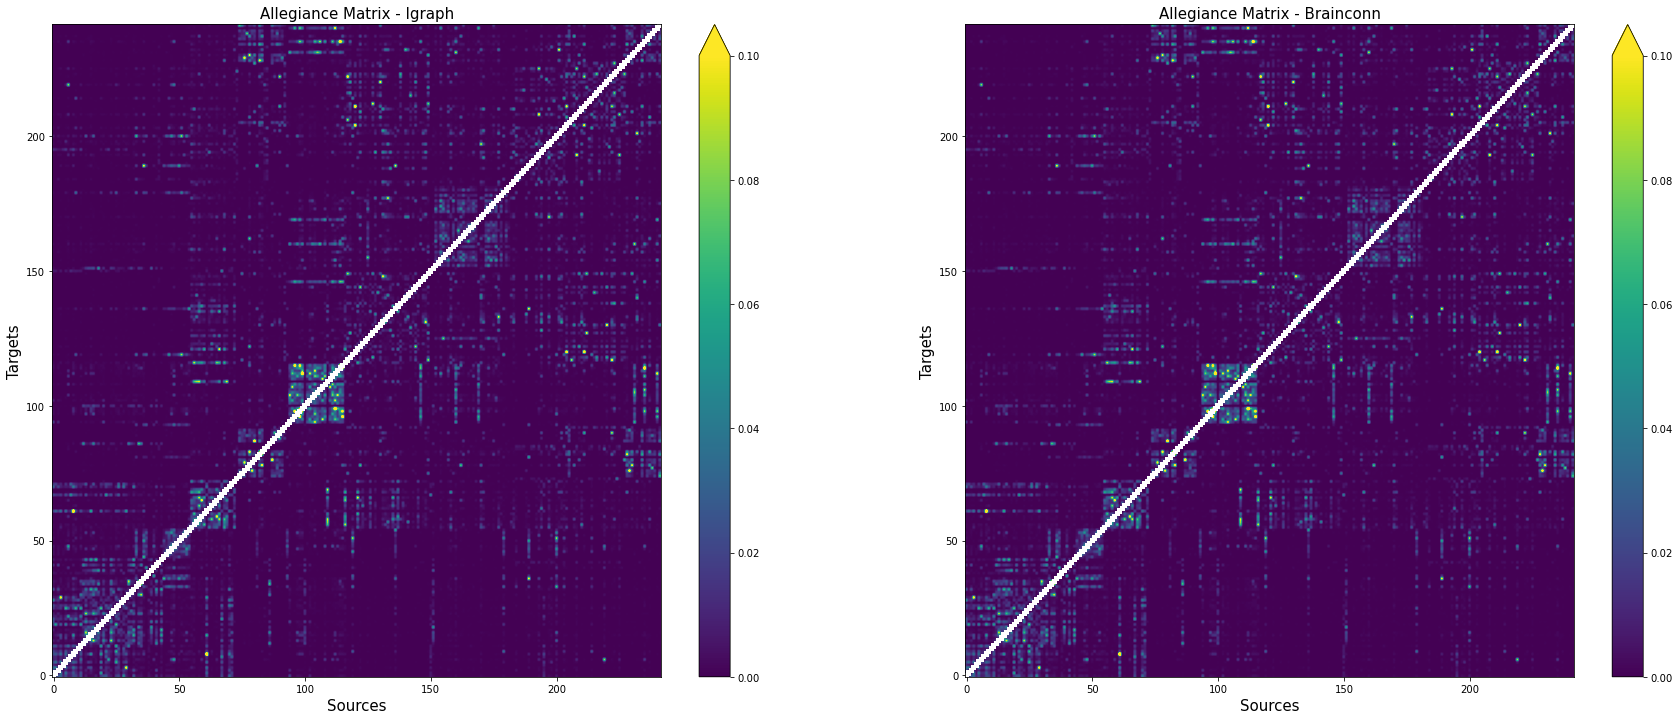

In [7]:
plt.figure(figsize=(30,12))
plt.subplot(1,2,1)
np.fill_diagonal(T_ig.values,np.nan)
plt.imshow(T_ig, aspect="auto",cmap="viridis",origin="lower", vmin=0, vmax=0.1)
#plt.xticks(range(T_ig.sizes['sources']),T_ig.sources.values, rotation=270)
#plt.yticks(range(T_ig.sizes['sources']),T_ig.targets.values)
plt.title('Allegiance Matrix - Igraph', fontsize=15)
plt.xlabel('Sources', fontsize=15)
plt.ylabel('Targets', fontsize=15)
plt.colorbar(extend='max');
plt.subplot(1,2,2)
np.fill_diagonal(T_bc.values,np.nan)
plt.imshow(T_bc, aspect="auto",cmap="viridis",origin="lower", vmin=0, vmax=0.1)
#plt.xticks(range(T_ig.sizes['sources']),T_ig.sources.values, rotation=270)
#plt.yticks(range(T_ig.sizes['sources']),T_ig.targets.values)
plt.title('Allegiance Matrix - Brainconn', fontsize=15)
plt.xlabel('Sources', fontsize=15)
plt.ylabel('Targets', fontsize=15)
plt.colorbar(extend='max');

#### Windowed nodes' allegiance matrix

In [8]:
WT_ig = windowed_allegiance_matrix(A, times=A.times.values, verbose=False, win_args=dict(slwin_len=20, slwin_step=10), backend='igraph', n_jobs=1)

Defining temporal windows
    Definition of sliding windows (len=20, start=0, stop=3099, step=10)
    308 windows defined


  0%|          |  : 0/1 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

In [ ]:
WT_bc = windowed_allegiance_matrix(A, times=A.times.values, verbose=False, win_args=dict(slwin_len=20, slwin_step=10), backend='brainconn', n_jobs=-1)

In [9]:
for t in tqdm( range( WT_ig.sizes['times'] ) ):
    plt.figure(figsize=(15,12))
    np.fill_diagonal(WT_ig.values[:,:,0,t],np.nan)
    plt.imshow(WT_ig.values[:,:,0,t],aspect='auto',origin='lower',cmap='viridis', vmin=0, vmax=0.5)
    plt.title(f'Allegiance Matrix, t={WT_ig.times.values[t]}', fontsize=15)
    plt.xlabel('Sources', fontsize=15)
    plt.ylabel('Targets', fontsize=15)
    plt.colorbar(extend='max');
    plt.savefig(f'figures/am_{t}.png')
    plt.close()

100%|██████████| 308/308 [01:01<00:00,  5.05it/s]


In [ ]:
for t in tqdm( range( WT_ig.sizes['times'] ) ):
    plt.figure(figsize=(15,12))
    np.fill_diagonal(WT_ig.values[:,:,0,t],np.nan)
    plt.imshow(WT_ig.values[:,:,0,t],aspect='auto',origin='lower',cmap='viridis', vmin=0, vmax=0.5)
    plt.title(f'Allegiance Matrix, t={WT_ig.times.values[t]}', fontsize=15)
    plt.xlabel('Sources', fontsize=15)
    plt.ylabel('Targets', fontsize=15)
    plt.colorbar(extend='max');
    plt.savefig(f'figures/am_bc_{t}.png')
    plt.close()

### Tests

In [135]:
from net.util import _check_inputs, _unwrap_inputs, _is_binary

In [165]:
_DEFAULT_TYPE = np.float32

def compute_nodes_coreness_bc(A, verbose=False, n_jobs=1):
    r'''
    Given the multiplex adjacency matrix A with shape (roi,roi,trials,time), the coreness for each
    node is computed for all the trials concatenated.
    > INPUTS:
    - A: Multiplex adjacency matrix with shape (roi,roi,trials,time).
    - is_weighted: Scepecify if the network is weighted or binary.
    - verbose: Wheater to print the progress or not.
    - n_jobs: Number of jobs to use when parallelizing in observations.
    > OUTPUTS:
    - coreness: A matrix containing the nodes coreness with shape (roi,trials,time).
    '''
    # Check inputs
    _check_inputs(A, 4)
    # Get values in case it is an xarray
    A, roi, trials, time = _unwrap_inputs(A,concat_trials=True)
    # Check if the matrix is weighted or binary
    is_weighted = not _is_binary(A)
    #  Number of channels
    nC = A.shape[0]
    #  Number of observations
    nt = A.shape[-1]
    #  Variable to store node coreness
    #  coreness  = np.zeros([nC,nt])
    
    def _nodes_kcore_bu(A):
        # Number of nodes
        n_nodes = len(A)
        # Initial coreness
        k       = 0
        # Store each node's coreness
        k_core  = np.zeros(n_nodes)
        # Iterate until get a disconnected graph
        while True:
            # Get coreness matrix and level of k-core
            C, kn = bc.core.kcore_bu(A,k,peel=False)
            if kn==0: 
                break
            # Assigns coreness level to nodes
            idx = C.sum(1)>0
            k_core[idx]=k
            k+=1
        return k_core+1

    # Compute for a single observation
    def _for_frame(t):
        coreness = _nodes_kcore_bu(A[...,t])
        return coreness

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_frame, n_jobs=n_jobs, verbose=verbose,
        total=nt)
    # Compute the single trial coherence
    coreness = parallel(p_fun(t) for t in range(nt))
    # Convert to numpy array
    coreness = np.asarray(coreness).T

    # Unstack trials and time
    coreness = coreness.reshape( (len(roi),len(trials),len(time)) )
    # Convert to xarray
    coreness = xr.DataArray(coreness.astype(_DEFAULT_TYPE), dims=("roi","trials","times"),
                              coords={"roi": roi, "times": time, "trials": trials} )

    return coreness

In [166]:
k_core_bc = compute_nodes_coreness_bc(A, verbose=True, n_jobs=-1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 3100 out of 3100 | elapsed:   12.4s finished


In [167]:
#k_core_bc = np.zeros((A.sizes['sources'],A.sizes['times']))
#for t in tqdm( range(A.sizes['times']) ):
#    k_core_bc[...,t]=_nodes_kcore_bu(A[...,0,t].values)

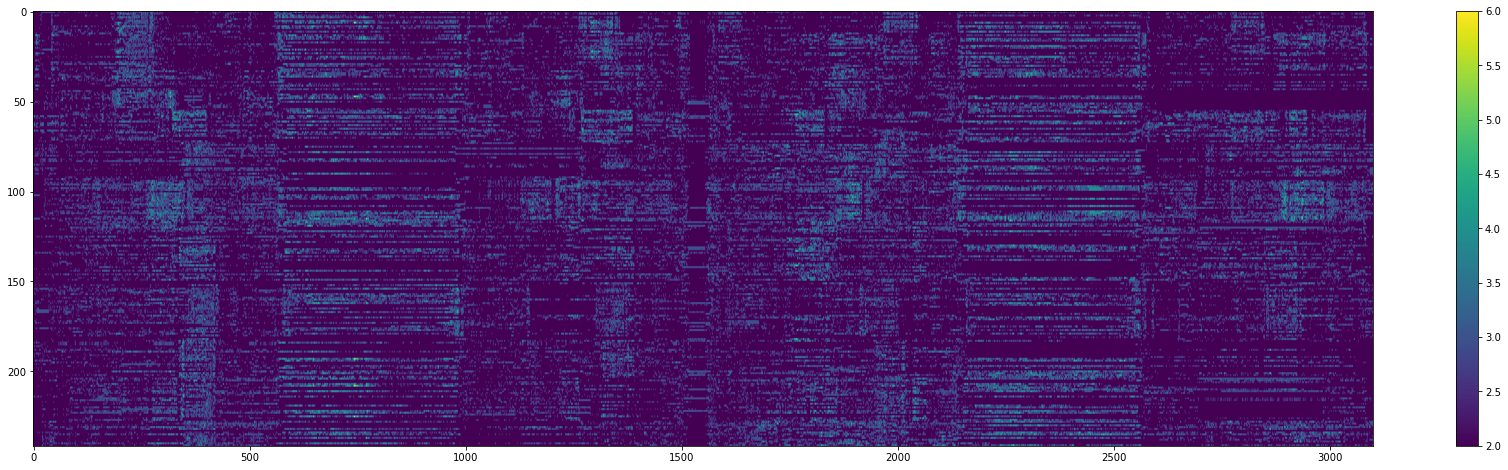

In [168]:
plt.figure(figsize=(30,8))
plt.imshow(k_core.isel(trials=0), aspect='auto', cmap='viridis')
plt.colorbar()

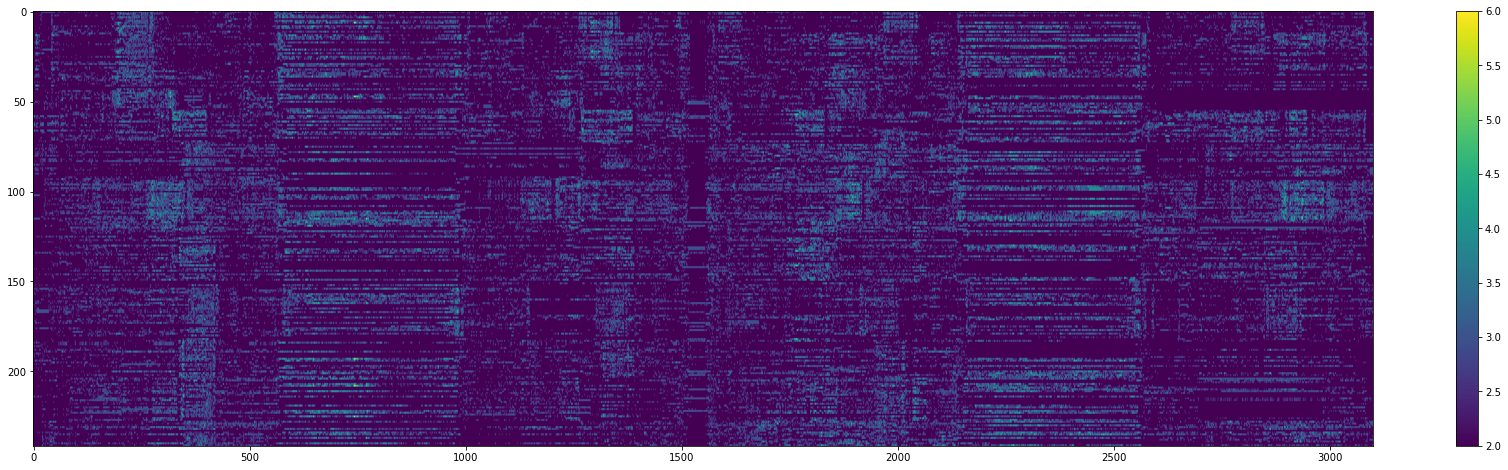

In [169]:
plt.figure(figsize=(30,8))
plt.imshow(k_core_bc.squeeze(), aspect='auto', cmap='viridis')
plt.colorbar()

In [102]:
_nodes_kcore_bu(A[...,0,10].values)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 3., 1.,
       3., 2., 1., 3., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 1., 3., 1.,
       1., 2., 1., 1., 1., 2., 1., 3., 1., 3., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 2., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1.,
       2., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 2., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2.,
       1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [90]:
C, kn = bc.core.kcore_bu(A[...,0,t].values,3,peel=False)

In [94]:
np.where( C.sum(1)>0 )

(array([125, 167, 180]),)

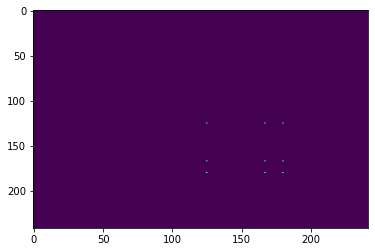

In [92]:
plt.imshow(C, aspect='auto', cmap='viridis')

In [78]:
kl=[]
for t in tqdm( range(A.sizes['times']) ):
    k = 0
    while True:
        _,kn = bc.core.kcore_bu(A[...,0,t].values,k,peel=False)
        if kn==0:
            break
        k    = k + 1
    kl += [k]

100%|██████████| 3100/3100 [00:17<00:00, 176.94it/s]


array([3., 3., 4., ..., 3., 3., 4.], dtype=float32)

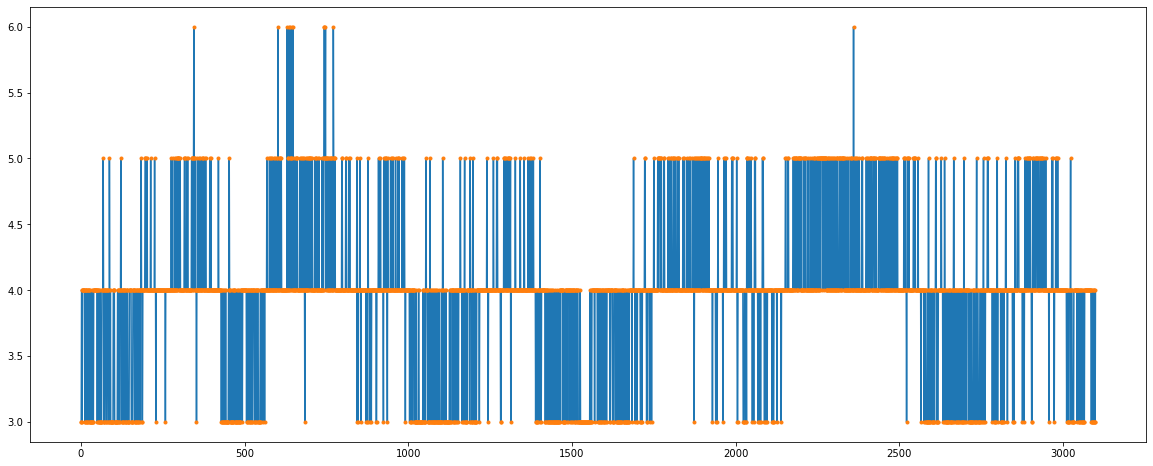

In [87]:
plt.figure(figsize=(20,8))
plt.plot(k_core.max(dim="roi").isel(trials=0).values)
plt.plot(kl, '.')

In [66]:
bc.core.kcore_bu(A[...,0,0].values,4,peel=False)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 0)

In [23]:
from sklearn.metrics import mutual_info_score

<xarray.DataArray (roi: 242, trials: 1, times: 3100)>
array([[[  0,   0,   0, ...,   0,   0,   0]],

       [[  1,   1,   1, ...,   1,   1,   1]],

       [[  2,   2,   2, ...,   2,   2,   2]],

       ...,

       [[231, 231, 229, ..., 226, 217, 221]],

       [[232, 232, 230, ..., 227, 218, 222]],

       [[233, 233, 231, ..., 228, 219, 223]]])
Coordinates:
  * roi      (roi) int64 0 1 2 3 4 5 6 7 8 ... 234 235 236 237 238 239 240 241
  * trials   (trials) int64 0
  * times    (times) int64 0 1 2 3 4 5 6 ... 3093 3094 3095 3096 3097 3098 3099

In [25]:
x = p_bc.isel(trials=0,times=10).values
y = p_bc.isel(trials=0,times=11).values

In [31]:
bins_x = np.arange(x.min(),x.max(),dtype=int)
bins_y = np.arange(y.min(),y.max(),dtype=int)

In [38]:
c_x, _ = np.histogram(x, bins=bins_x); c_x = c_x/np.sum(c_x)
c_y, _ = np.histogram(y, bins=bins_y); c_y = c_y/np.sum(c_y)

In [46]:
c_xy,_,_ = np.histogram2d(x,y,bins=[bins_x,bins_y]); c_xy = c_xy/np.sum(c_xy) 

In [50]:
np.nanmean(np.log(1/c_xy))

<ipython-input-50-f778fcaef925>:1: RuntimeWarning: divide by zero encountered in true_divide
  np.nanmean(np.log(1/c_xy))


inf

In [52]:
np.log(1/c_xy)

<ipython-input-52-13cd3e0f58df>:1: RuntimeWarning: divide by zero encountered in true_divide
  np.log(1/c_xy)


array([[5.48479693,        inf,        inf, ...,        inf,        inf,
               inf],
       [       inf, 5.48479693,        inf, ...,        inf,        inf,
               inf],
       [       inf,        inf, 5.48479693, ...,        inf,        inf,
               inf],
       ...,
       [       inf,        inf,        inf, ..., 5.48479693,        inf,
               inf],
       [       inf,        inf,        inf, ...,        inf, 5.48479693,
               inf],
       [       inf,        inf,        inf, ...,        inf,        inf,
        4.79164975]])